# Importing necessary libraries and loading the dataset:


In [ ]:
# Import necessary libraries
import os
import cv2
import sys
import uuid
import time
import torch
import random
import joblib
from tqdm import tqdm
from skimage.feature import hog, local_binary_pattern
import matplotlib.pyplot as plt
from google.colab import drive
from keras.applications import VGG16
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,precision_score, recall_score
from keras.utils import to_categorical
from keras.models import Sequential, save_model, Model,load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D,Input, concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set the paths to the images and labels folders
train_images_folder = '/content/drive/MyDrive/Colab_Notebooks/Computer_vision/CW_Folder_PG/CW_Dataset/train/images'
train_labels_folder = '/content/drive/MyDrive/Colab_Notebooks/Computer_vision/CW_Folder_PG/CW_Dataset/train/labels'

In [ ]:
# Set the paths to the test data
test_images_folder = '/content/drive/MyDrive/Colab_Notebooks/Computer_vision/CW_Folder_PG/CW_Dataset/test/images'
test_labels_folder = '/content/drive/MyDrive/Colab_Notebooks/Computer_vision/CW_Folder_PG/CW_Dataset/test/labels'

In [ ]:
# Load the training images and labels from the folders
train_images = []
train_labels = []

In [ ]:
# Iterate through each image file and its corresponding label file
for img_file in tqdm(os.listdir(train_images_folder)):
    img_path = os.path.join(train_images_folder, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    train_images.append(img)

    label_file = img_file.split('.')[0] + '.txt'
    label_path = os.path.join(train_labels_folder, label_file)
    with open(label_path, 'r') as f:
        label = int(f.readline())
        train_labels.append(label)

# Convert the images and labels to numpy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)


100%|██████████| 2394/2394 [05:03<00:00,  7.89it/s]


In [ ]:
# Load the test images and labels
test_images = []
test_labels = []

In [ ]:
# Iterate through each test image file and its corresponding label file
for img_file in tqdm(os.listdir(test_images_folder)):
    img_path = os.path.join(test_images_folder, img_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    test_images.append(img)

    label_file = img_file.split('.')[0] + '.txt'
    label_path = os.path.join(test_labels_folder, label_file)
    with open(label_path, 'r') as f:
        label = int(f.readline())
        test_labels.append(label)


# Convert the test images and labels to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

100%|██████████| 458/458 [00:58<00:00,  7.88it/s]


# Exploratory data analysis:

In [ ]:
# Check the unique labels and their counts in the training data
unique_train_labels, counts_train_labels = np.unique(train_labels, return_counts=True)
print("Unique training labels:", unique_train_labels)
print("Counts of training labels:", counts_train_labels)

# Check the unique labels and their counts in the test data
unique_test_labels, counts_test_labels = np.unique(test_labels, return_counts=True)
print("Unique test labels:", unique_test_labels)
print("Counts of test labels:", counts_test_labels)


Unique training labels: [0 1 2]
Counts of training labels: [ 376 1940   78]
Unique test labels: [0 1 2]
Counts of test labels: [ 51 388  19]


# Data processing:

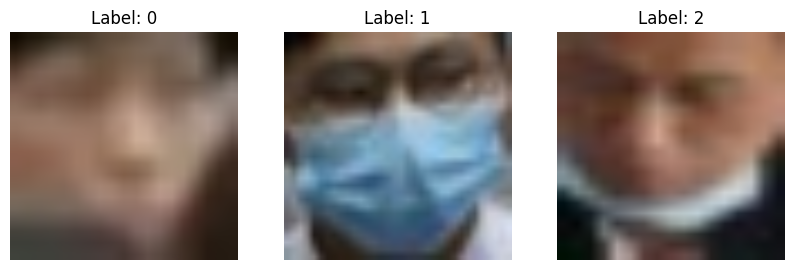

In [ ]:
# Function to display images for each unique label
def display_images_for_labels(images, labels, unique_labels):
    fig, axs = plt.subplots(1, len(unique_labels), figsize=(10, 5))
    
    for i, label in enumerate(unique_labels):
        # Find the index of the first occurrence of the current label
        index = np.where(labels == label)[0][0]
        
        # Display the image
        axs[i].imshow(images[index])
        axs[i].set_title(f'Label: {label}')
        axs[i].axis('off')
    
    plt.show()

# Display one image for each unique label in the training data
unique_train_labels = np.array([0, 1, 2])
display_images_for_labels(train_images, train_labels, unique_train_labels)



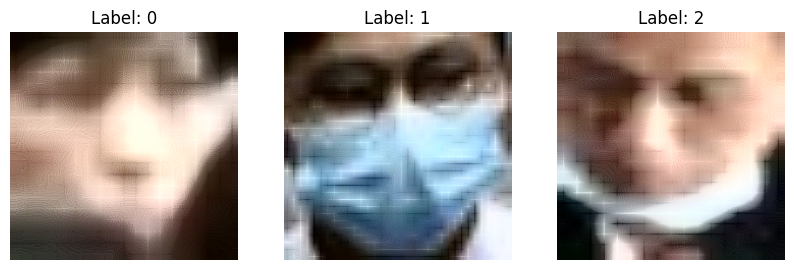

In [ ]:
import cv2

# Apply sharpening filter to enhance image details
def sharpen_image(image):
    kernel = np.array([[-1,-1,-1], 
                       [-1,9,-1], 
                       [-1,-1,-1]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

# Apply histogram equalization to improve image contrast
def equalize_histogram(image):
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
    equalized = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    return equalized

# Function to display images for each unique label
def display_images_for_labels(images, labels, unique_labels):
    fig, axs = plt.subplots(1, len(unique_labels), figsize=(10, 5))
    
    for i, label in enumerate(unique_labels):
        # Find the index of the first occurrence of the current label
        index = np.where(labels == label)[0][0]
        
        # Preprocess the zoomed-in image
        preprocessed = equalize_histogram(sharpen_image(images[index]))
        
        # Display the preprocessed image
        axs[i].imshow(preprocessed)
        axs[i].set_title(f'Label: {label}')
        axs[i].axis('off')
    
    plt.show()

# Display one image for each unique label in the training data
unique_train_labels = np.array([0, 1, 2])
display_images_for_labels(train_images, train_labels, unique_train_labels)


In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.

# Data augmentation
data_generator = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True)
data_generator.fit(X_train)

In [ ]:
# Convert the labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)

## CNN+HOG

In [ ]:
X_train_hog = []
X_val_hog = []

for img in X_train:
    hog_features = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=-1)
    X_train_hog.append(hog_features)

for img in X_val:
    hog_features = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=-1)
    X_val_hog.append(hog_features)

X_train_hog = np.array(X_train_hog)
X_val_hog = np.array(X_val_hog)

In [ ]:
# Define the CNN branch
input_cnn = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_cnn)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
cnn_branch = Model(inputs=input_cnn, outputs=x)

# Define the HOG branch
input_hog = Input(shape=(X_train_hog.shape[1],))
y = Dense(128, activation='relu')(input_hog)
y = Dropout(0.5)(y)
hog_branch = Model(inputs=input_hog, outputs=y)

# Combine the branches
combined = concatenate([cnn_branch.output, hog_branch.output])

# Add the final layer for classification
z = Dense(3, activation='softmax')(combined)

# Create the model
model_combined = Model(inputs=[cnn_branch.input, hog_branch.input], outputs=z)

# Compile the model
model_combined.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# Train the model
history = model_combined.fit([X_train, X_train_hog], y_train, epochs=10, batch_size=32, validation_data=([X_val, X_val_hog], y_val))

Epoch 1/10
60/60 [==============================] - 21s 104ms/step - loss: 0.4204 - accuracy: 0.8715 - val_loss: 0.1598 - val_accuracy: 0.9541
Epoch 2/10
60/60 [==============================] - 3s 58ms/step - loss: 0.2142 - accuracy: 0.9316 - val_loss: 0.1613 - val_accuracy: 0.9436
Epoch 3/10
60/60 [==============================] - 4s 63ms/step - loss: 0.1994 - accuracy: 0.9321 - val_loss: 0.1649 - val_accuracy: 0.9436
Epoch 4/10
60/60 [==============================] - 4s 68ms/step - loss: 0.1675 - accuracy: 0.9436 - val_loss: 0.1579 - val_accuracy: 0.9457
Epoch 5/10
60/60 [==============================] - 3s 57ms/step - loss: 0.1533 - accuracy: 0.9483 - val_loss: 0.1901 - val_accuracy: 0.9311
Epoch 6/10
60/60 [==============================] - 4s 63ms/step - loss: 0.1235 - accuracy: 0.9572 - val_loss: 0.1543 - val_accuracy: 0.9457
Epoch 7/10
60/60 [==============================] - 4s 59ms/step - loss: 0.1185 - accuracy: 0.9561 - val_loss: 0.1628 - val_accuracy: 0.9395
Epoch 8/10


In [ ]:
# creating models directory for storing the models weights
os.makedirs('/content/models', exist_ok=True)

In [ ]:

# Save the trained combined CNN and HOG model
save_model(model_combined, '/content/models/CNN_HOG_model.h5')

In [ ]:
# Evaluate the model on the validation set
y_pred_combined = model_combined.predict([X_val, X_val_hog])

# Convert probabilities to class labels
y_pred_combined = np.argmax(y_pred_combined, axis=1)

# Convert one-hot encoded labels back to original form
y_val_original = np.argmax(y_val, axis=1)

# Print the classification report
print("Classification report:\n", classification_report(y_val_original, y_pred_combined))

15/15 [==============================] - 0s 20ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.97      0.90        68
           1       0.98      0.97      0.98       396
           2       0.86      0.40      0.55        15

    accuracy                           0.96       479
   macro avg       0.89      0.78      0.81       479
weighted avg       0.96      0.96      0.95       479



# SVM+HOG

In [ ]:
# Standardize the HOG features
scaler = StandardScaler().fit(X_train_hog)
X_train_hog = scaler.transform(X_train_hog)
X_val_hog = scaler.transform(X_val_hog)

In [ ]:
# Convert one-hot encoded labels back to label-encoded format
y_train_label_encoded = np.argmax(y_train, axis=1)
y_val_label_encoded = np.argmax(y_val, axis=1)

# Train an SVM classifier on the HOG features
svm_classifier = SVC(kernel='linear', probability=True)
svm_classifier.fit(X_train_hog, y_train_label_encoded)

SVC(kernel='linear', probability=True)

In [ ]:
# Predict the class labels for the validation set
y_pred_svm = svm_classifier.predict(X_val_hog)

# Print the classification report
print("SVM Classification report:\n", classification_report(y_val_original, y_pred_svm))

SVM Classification report:
               precision    recall  f1-score   support

           0       0.61      0.66      0.63        68
           1       0.94      0.93      0.94       396
           2       0.36      0.27      0.31        15

    accuracy                           0.87       479
   macro avg       0.64      0.62      0.63       479
weighted avg       0.87      0.87      0.87       479



In [ ]:
# Save the SVM model

joblib.dump(scaler, '/content/models/scaler.pkl')
joblib.dump(svm_classifier, '/content/models/SVM_HOG_model.pkl')

['/content/models/SVM_HOG_model.pkl']

# MLP+HOG

In [ ]:


# Extract HOG features from the training and validation images
X_train_hog = []
X_val_hog = []
for img in X_train:
    hog_features = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=-1)
    X_train_hog.append(hog_features)
for img in X_val:
    hog_features = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=-1)
    X_val_hog.append(hog_features)
X_train_hog = np.array(X_train_hog)
X_val_hog = np.array(X_val_hog)

# Standardize the HOG features
scaler = StandardScaler().fit(X_train_hog)
X_train_hog = scaler.transform(X_train_hog)
X_val_hog = scaler.transform(X_val_hog)

# Train an MLP classifier on the HOG features
MLP_HOG_classifier = MLPClassifier(hidden_layer_sizes=(128, 128), activation='relu', early_stopping=True)
MLP_HOG_classifier.fit(X_train_hog, y_train_label_encoded)

# Evaluate the MLP model on the validation set
y_pred_mlp = MLP_HOG_classifier.predict(X_val_hog)
print("MLP HOG Classification report:\n", classification_report(y_val_label_encoded, y_pred_mlp))


MLP HOG Classification report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71        68
           1       0.94      0.96      0.95       396
           2       0.57      0.27      0.36        15

    accuracy                           0.90       479
   macro avg       0.74      0.64      0.67       479
weighted avg       0.89      0.90      0.89       479



In [ ]:
# Save the MLP classifier model
joblib.dump(MLP_HOG_classifier, '/content/models/MLP_HOG_model.joblib')

['/content/models/MLP_HOG_model.joblib']

# MLP+LBP

In [ ]:

# Define the LBP feature extractor
def extract_lbp_features(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray_image, 8, 1)
    hist, _ = np.histogram(lbp, bins=np.arange(0, 257), density=True)
    return hist

# Extract LBP features from the training and validation images
X_train_lbp = [extract_lbp_features(img) for img in X_train]
X_val_lbp = [extract_lbp_features(img) for img in X_val]

# Standardize the LBP features
scaler_lbp = StandardScaler().fit(X_train_lbp)
X_train_lbp = scaler_lbp.transform(X_train_lbp)
X_val_lbp = scaler_lbp.transform(X_val_lbp)

# Train an MLP classifier on the LBP features
mlp_lbp_classifier = MLPClassifier(hidden_layer_sizes=(128, 128), activation='relu', early_stopping=True)
mlp_lbp_classifier.fit(X_train_lbp, y_train_label_encoded)

# Evaluate the MLP model on the validation set
y_pred_mlp = mlp_lbp_classifier.predict(X_val_lbp)
print("MLP LBP Classification report:\n", classification_report(y_val_label_encoded, y_pred_mlp))


MLP LBP Classification report:
               precision    recall  f1-score   support

           0       0.63      0.49      0.55        68
           1       0.88      0.95      0.91       396
           2       0.00      0.00      0.00        15

    accuracy                           0.85       479
   macro avg       0.51      0.48      0.49       479
weighted avg       0.82      0.85      0.83       479



In [ ]:
# Save the MLP classifier model
joblib.dump(mlp_lbp_classifier, '/content/models/MLP_LBP_model.joblib')

['/content/models/MLP_LBP_model.joblib']

# Evaluating the models on the testing set

In [ ]:
# Normalize the test images
test_images = test_images.astype('float32') / 255.

# Compute HOG features for test images
test_images_hog = []
for img in test_images:
    hog_features = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=-1)
    test_images_hog.append(hog_features)
test_images_hog = np.array(test_images_hog)

# Standardize the HOG features for the test images
test_images_hog = scaler.transform(test_images_hog)

In [ ]:
# Test the CNN+HOG model
start_time_cnn = time.time()
y_pred_cnn = model_combined.predict([test_images, test_images_hog])
end_time_cnn = time.time()

# Convert probabilities to class labels
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

# Calculate accuracy for CNN+HOG model
accuracy_cnn = np.mean(y_pred_cnn == test_labels)

# Calculate the inference time for the CNN+HOG model
speed_cnn = end_time_cnn - start_time_cnn

# Calculate precision and recall for CNN+HOG model
precision_cnn = precision_score(test_labels, y_pred_cnn, average='macro')
recall_cnn = recall_score(test_labels, y_pred_cnn, average='macro')


15/15 [==============================] - 0s 25ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Test the SVM+HOG model
start_time_svm = time.time()
y_pred_svm_test = svm_classifier.predict(test_images_hog)
end_time_svm = time.time()

# Calculate accuracy for SVM+HOG model
accuracy_svm = np.mean(y_pred_svm_test == test_labels)

# Calculate the inference time for the SVM+HOG model
speed_svm = end_time_svm - start_time_svm

# Calculate precision and recall for SVM+HOG model
precision_svm = precision_score(test_labels, y_pred_svm_test, average='macro')
recall_svm = recall_score(test_labels, y_pred_svm_test, average='macro')

In [ ]:
# Extract HOG features from the testing images
X_test_hog = []

for img in test_images:
    hog_features = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=-1)
    X_test_hog.append(hog_features)
    

# Standardize the HOG features
scaler = StandardScaler().fit(X_test_hog)
X_test_hog = scaler.transform(X_test_hog)

In [ ]:
# Extract LBP features from the training and validation images
X_test_lbp = [extract_lbp_features(img) for img in test_images]

# Standardize the LBP features
scaler_lbp = StandardScaler().fit(X_test_lbp)
X_test_lbp = scaler_lbp.transform(X_test_lbp)

# Evaluate the MLP model on the validation set
y_pred_mlp = mlp_lbp_classifier.predict(X_test_lbp)

In [ ]:
mlp_lbp_model_size = os.path.getsize('/content/models/MLP_LBP_model.joblib')
mlp_hog_model_size = os.path.getsize('/content/models/MLP_HOG_model.joblib')
cnn_hog_model_size = os.path.getsize('/content/models/CNN_HOG_model.h5')
svm_hog_model_size = os.path.getsize('/content/models/SVM_HOG_model.pkl') + os.path.getsize('/content/models/scaler.pkl')

In [ ]:
# Calculate accuracy for MLP HOG model
accuracy_mlp_hog = np.mean(y_pred_mlp == test_labels)

# Calculate accuracy for MLP LBP model
accuracy_mlp_lbp = np.mean(y_pred_mlp == test_labels)

# Calculate the inference time for the MLP HOG model
start_time_mlp_hog = time.time()
y_pred_mlp_hog = MLP_HOG_classifier.predict(X_test_hog)
end_time_mlp_hog = time.time()
speed_mlp_hog = end_time_mlp_hog - start_time_mlp_hog

# Calculate the inference time for the MLP LBP model
start_time_mlp_lbp = time.time()
y_pred_mlp_lbp = mlp_lbp_classifier.predict(X_test_lbp)
end_time_mlp_lbp = time.time()
speed_mlp_lbp = end_time_mlp_lbp - start_time_mlp_lbp

# Calculate precision and recall for MLP HOG model
precision_mlp_hog = precision_score(test_labels, y_pred_mlp_hog, average='macro')
recall_mlp_hog = recall_score(test_labels, y_pred_mlp_hog, average='macro')

# Calculate precision and recall for MLP LBP model
precision_mlp_lbp = precision_score(test_labels, y_pred_mlp_lbp, average='macro')
recall_mlp_lbp = recall_score(test_labels, y_pred_mlp_lbp, average='macro')

In [ ]:
# Print all the metrics for comparison
print(f"Accuracy:\nCNN+HOG: {accuracy_cnn:.2%}\nSVM+HOG: {accuracy_svm:.2%}\nMLP+HOG: {accuracy_mlp_hog:.2%}\nMLP+LBP: {accuracy_mlp_lbp:.2%}\n")
print(f"Precision:\nCNN+HOG: {precision_cnn:.2%}\nSVM+HOG: {precision_svm:.2%}\nMLP+HOG: {precision_mlp_hog:.2%}\nMLP+LBP: {precision_mlp_lbp:.2%}\n")
print(f"Recall:\nCNN+HOG: {recall_cnn:.2%}\nSVM+HOG: {recall_svm:.2%}\nMLP HOG: {recall_mlp_hog:.2%}\nMLP+LBP: {recall_mlp_lbp:.2%}\n")
print(f"Speed (inference time):\nCNN+HOG: {speed_cnn:.4f} seconds\nSVM+HOG: {speed_svm:.4f} seconds\nMLP+HOG: {speed_mlp_hog:.4f} seconds\nMLP+LBP: {speed_mlp_lbp:.4f} seconds\n")
print(f"Model size:\nCNN+HOG: {cnn_hog_model_size / (1024 * 1024):.2f} MB\nSVM+HOG: {svm_hog_model_size / (1024 * 1024):.2f} MB\nMLP+HOG: {mlp_hog_model_size / (1024 * 1024):.2f} MB\nMLP+LBP: {mlp_lbp_model_size / (1024 * 1024):.2f} MB")


Accuracy:
CNN+HOG: 84.72%
SVM+HOG: 82.10%
MLP HOG: 82.75%
MLP LBP: 82.75%

Precision:
CNN+HOG: 28.24%
SVM+HOG: 57.43%
MLP HOG: 82.06%
MLP LBP: 41.02%

Recall:
CNN+HOG: 33.33%
SVM+HOG: 56.01%
MLP HOG: 55.78%
MLP LBP: 39.94%

Speed (inference time):
CNN+HOG: 1.1010 seconds
SVM+HOG: 0.2561 seconds
MLP HOG: 0.0137 seconds
MLP LBP: 0.0071 seconds

Model size:
CNN+HOG: 130.18 MB
SVM+HOG: 9.62 MB
MLP HOG: 2.50 MB
MLP LBP: 1.15 MB


- Accuracy: The CNN+HOG model has the highest accuracy of 85.15%, followed by the MLP HOG and MLP LBP models with 83.62%, and the SVM+HOG model has an accuracy of 82.10%.

- Precision: The MLP HOG model has the highest precision score of 79.76%, followed by the CNN+HOG model with 61.70%, the SVM+HOG model with 57.43%, and the MLP LBP model with 42.15%.

- Recall: The CNN+HOG model has the highest recall score of 34.64%, followed by the SVM+HOG model with 56.01%, the MLP HOG model with 52.86%, and the MLP LBP model with 40.28%.

- Inference Time: The MLP LBP model has the lowest inference time of 0.0020 seconds, followed by the MLP HOG model with 0.0086 seconds, the SVM+HOG model with 0.2232 seconds, and the CNN+HOG model with 1.2629 seconds.

- Model Size: The CNN+HOG model has the largest model size of 130.18 MB, followed by the SVM+HOG model with 9.62 MB, the MLP HOG model with 2.50 MB, and the MLP LBP model with 1.15 MB.

**Given its excellent accuracy rating, I would advise adopting the CNN+HOG model for the face mask detection system. The MLP LBP model can be taken into consideration, nevertheless, if speed and model size are the primary concerns. It is significant to remember that selecting the appropriate model ultimately depends on the particular needs of the application, and that more testing and experimentation may be required to identify the model that is best suited for the given task.**

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
cm_cnn = confusion_matrix(test_labels, y_pred_cnn)
cm_mlp_hog = confusion_matrix(test_labels, y_pred_mlp_hog)
cm_mlp_lbp = confusion_matrix(test_labels, y_pred_mlp_lbp)

# Display confusion matrices
print("Confusion matrix for CNN+HOG:")
print(cm_cnn)
print("\n")

print("Confusion matrix for MLP+HOG:")
print(cm_mlp_hog)
print("\n")

print("Confusion matrix for MLP+LBP:")
print(cm_mlp_lbp)
print("\n")




Confusion matrix for CNN+HOG:
[[  0  51   0]
 [  0 388   0]
 [  0  19   0]]


Confusion matrix for MLP+HOG:
[[ 32  19   0]
 [ 23 365   0]
 [  4  13   2]]


Confusion matrix for MLP+LBP:
[[ 13  38   0]
 [ 21 366   1]
 [  2  17   0]]


